# **Intro:**  

White blood cells are the backbone of our Immune system, they work to fight off pathogens in the body every minute to keep us healthy. There are different types of white blood cells that serve unique purposes, from killing off bacteria and parasites to manufacturing antibody proteins. It is important for medical practitioners and research scientists to identify the different cell types to find irregularities in white blood cell levels. In this notebook, we constructed and compared the performance and accuracy of a few classifiers in identifying white blood cell types. We decided to compare the performance of a decision tree, convolutional neural network, and a vision transformer.

The dataset we used is a collection of normal peripheral white blood cells images called Raabin-WBC containing about 40,000 images of white blood cells and color spots. The images are of 5 classes with each corresponding to a different type of white blood cell, which are Basophil, Lymphocyte, Monocyte, Eosinophil, and Neutrophil. We found this dataset to be of high quality not only due to the high resolution images captured by diverse microscope and camera setups, but because every type of cell is precisely labeled by two microbiology experts as well. The dataset came prepared with one training set and two testing sets, we will mainly be using the first TestA to evaluate the accuracy of our models.

  
     
First we load the raw datasets, since it came with a separate training and testing set, there is no need for us to split the data.

In [2]:
# Dataloader
import os
import PIL
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
import timm
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler
from PIL import UnidentifiedImageError
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Load raw datasets first (no transforms yet)
raw_train_dataset = datasets.ImageFolder(root='dataset/Train')
raw_testA_dataset = datasets.ImageFolder(root='dataset/TestA')
raw_testB_dataset = datasets.ImageFolder(root='dataset/Test-B')

testA_loader = DataLoader(raw_testA_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count() // 2)
testB_loader = DataLoader(raw_testB_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count() // 2)

Just to make sure the data is loaded correctly, lets visualize what the first image of the first dataset looks like. Also, we included the total number of samples in this training dataset, as well as the 5 different classes we will be classifying:

Training samples: 10175
Classes: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']


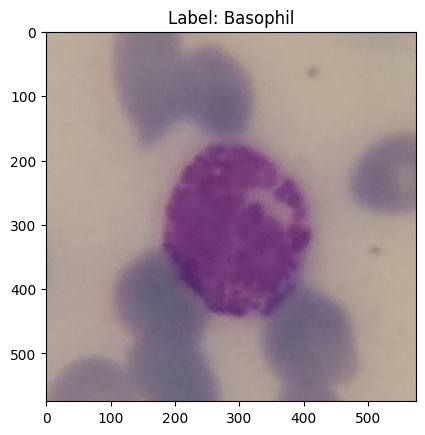

In [3]:
# TEST AND VISUALIZE DATASET BELOW ------------------------------------------------
print(f"Training samples: {len(raw_train_dataset)}")
print(f"Classes: {raw_train_dataset.classes}")


image, label = raw_train_dataset[0]  #this shows the first image under the train dataset (first image under basophil)
plt.imshow(image)
plt.title(f"Label: {raw_train_dataset.classes[label]}")
plt.show() # Note!!! The image is normalized, so it looks pretty dark when plt.show().


Now, to show just how unevenly these datasets are distributed, lets graph them visually:

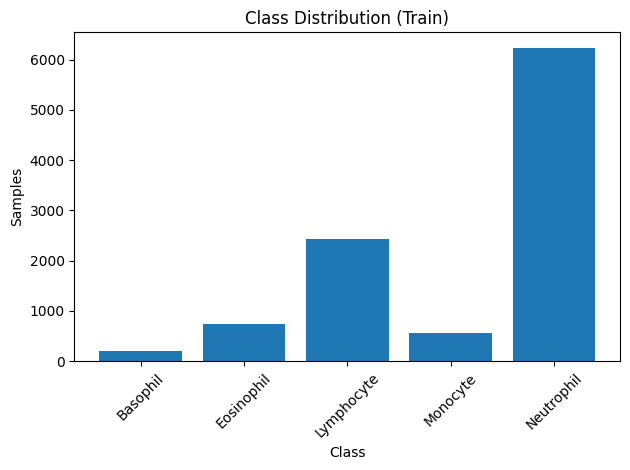

In [4]:
# Plot distribution
def plot_class_distribution(dataset, title):
    class_counts = Counter([label for _, label in dataset])
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.bar(labels, counts)
    plt.xticks(labels, [dataset.classes[i] for i in labels], rotation=45)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Samples")
    plt.tight_layout()
    plt.show()

plot_class_distribution(raw_train_dataset, "Class Distribution (Train)")

Since there is a pretty significantly uneven class distribution, we make a sampler function with balanced class weights to ensure a more even distribution:

In [5]:
def make_balanced_sampler(dataset):
    class_counts = Counter([label for _, label in dataset])
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    weights = [class_weights[label] for _, label in dataset]
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Models  
**Decision Tree:**  
 To start us off, lets take a look at the Decision Tree. The Decision Tree acts as a "lower level" model for comparison on this dataset. It serves to show how accurate the data can be on a decent-enough well-rounded model, as compared to two more advanced models; one of which is much more specialized to a dataset such as this.

Original feature shape: (10175, 49152)
Shape after PCA: (8140, 100)


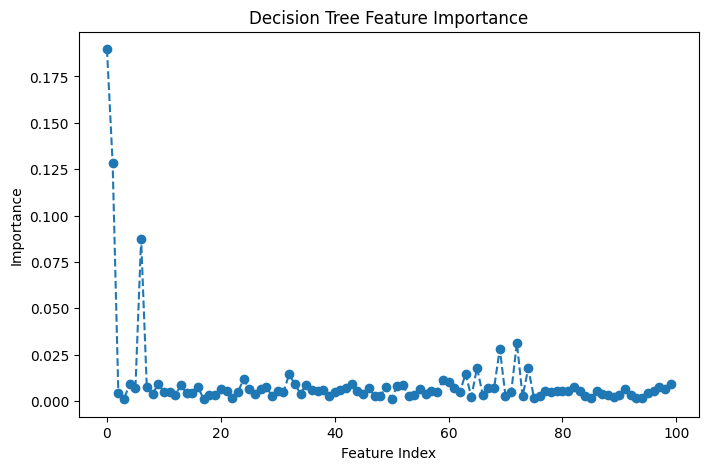

Decision Tree train accuracy: 100.00%
Decision Tree test accuracy: 86.34%

Classification Report:
               precision    recall  f1-score   support

    Basophil       0.98      1.00      0.99       365
  Eosinophil       0.82      0.96      0.89       369
  Lymphocyte       0.83      0.84      0.84       427
    Monocyte       0.87      0.96      0.91       415
  Neutrophil       0.82      0.61      0.70       459

    accuracy                           0.86      2035
   macro avg       0.86      0.87      0.86      2035
weighted avg       0.86      0.86      0.86      2035



In [11]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from torch.utils.data import Subset



#The following makes sure the given image is transformed before feeding into the model.
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
raw_train_dataset.transform = transform

balanced_sampler = make_balanced_sampler(raw_train_dataset) #use the balanced_sample function from above
balanced_indices = list(balanced_sampler)  #get the indices from the sampler
balanced_train_dataset = Subset(raw_train_dataset, balanced_indices)




#this following function gets features and labels from a given dataset. It also flattens each image into a 1D array.
def get_features_labels(dataset):
    features = []
    labels =[]
    for image, label in dataset:
        features.append(image.view(-1).numpy())
        labels.append(label)
    return np.array(features), np.array(labels)




X, y = get_features_labels(balanced_train_dataset)
print("Original feature shape:", X.shape)

#split data into training and test sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




#Apply PCA to reduce dimensions:
pca = PCA(n_components=100, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print("Shape after PCA:", X_train.shape)




#htrain dataset on the Decision Tree classifier:
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt.fit(X_train, y_train)

#predict on both sets:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)


#evaluate accuracy on both sets:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


#graph feature importance
importances = dt.feature_importances_
plt.figure(figsize=(8, 5))
plt.plot(importances, marker="o", linestyle="dashed")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Decision Tree Feature Importance")
plt.show()



print("Decision Tree train accuracy: {:.2f}%".format(train_accuracy*100))
print("Decision Tree test accuracy: {:.2f}%".format(test_accuracy*100))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=raw_train_dataset.classes))



First of all, this last segment of code shows the sheer size of the shape of this feature, as compared to the size after PCA is applied, allowing the model to learn from data after reducing dimensionality immensely. Furthermore, as you can see from the graph, after applying PCA the features that have the highest importance in this Decision Tree are at value 0 (meaning the first principal component). This is where most of the relevant information is captured. The graph also shows variance around features of size 7-8 or around 65-75. After running this code several times, however, it's becoming clear that the only consistently high importance feature for this data on this decision tree is at value 0.  

Most of the valuable information however, is in the table below this graph.  This graph shows the overall test accuracy at 86.34%, as well as the individual test accuracies on each of the five classes. This was done using pytorch's classification_report, which also shows the recall, f1-score, and support.  

Each of these stats are pretty decent, but could definitely be improved upon.

**Convoluted Neural Network:**  
(Info Here)

In [ ]:
# CNN

Vision Transformer:

In [ ]:


# Vision Transformer
IMG_SIZE = 224

vit_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # adjust for grayscale
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=vit_transform)
testA_dataset = datasets.ImageFolder(root='dataset/TestA', transform=vit_transform)
testB_dataset = datasets.ImageFolder(root='dataset/Test-B', transform=vit_transform)

# Split trainingdata into training and validation sets
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=os.cpu_count() // 2)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=os.cpu_count() // 2)

# # Load pretrained ViT
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=5)
# model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=5)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Get class indices from the dataset
class_indices = [label for _, label in train_ds]

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_indices), y=class_indices)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss with class weights and adam optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Dynamic scaler to prevent underflow and speeds up training
scaler = torch.amp.GradScaler()

# Begin training
best_val_acc = 0.0
EPOCHS = 5

# For visualization
train_losses = []
val_accuracies = []
train_accuracies = []


for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        try:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # udate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        except PIL.UnidentifiedImageError as e:
            print(f"Skipping corrupted image: {e}")
            continue

    avg_train_loss = running_loss / total
    train_acc = correct / total

    # Store train metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_model.pth")

    print(f'Epoch {epoch+1}/{EPOCHS}, '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

def evaluate_vit(model, loader, name):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"{name} Accuracy: {correct / total:.4f}")

def evaluate_vit_detailed(model, loader, name):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n{name} Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=testA_dataset.classes))

# Load best model
model.load_state_dict(torch.load("best_vit_model.pth"))

# Evaluate
evaluate_vit(model, testA_loader, "TestA")
evaluate_vit_detailed(model, testA_loader, "TestA")

plt.figure(figsize=(10, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Train Loss: 0.2963, Train Acc: 0.8974, Val Loss: 0.0685, Val Acc: 0.9784
Epoch 2/20, Train Loss: 0.0772, Train Acc: 0.9714, Val Loss: 0.1455, Val Acc: 0.9758
Epoch 3/20, Train Loss: 0.0747, Train Acc: 0.9769, Val Loss: 0.1034, Val Acc: 0.9895
Epoch 4/20, Train Loss: 0.0450, Train Acc: 0.9838, Val Loss: 0.0766, Val Acc: 0.9862
Epoch 5/20, Train Loss: 0.0291, Train Acc: 0.9888, Val Loss: 0.0892, Val Acc: 0.9915
Epoch 6/20, Train Loss: 0.0348, Train Acc: 0.9870, Val Loss: 0.0665, Val Acc: 0.9810
Epoch 7/20, Train Loss: 0.0185, Train Acc: 0.9933, Val Loss: 0.0545, Val Acc: 0.9895
Epoch 8/20, Train Loss: 0.0288, Train Acc: 0.9891, Val Loss: 0.0793, Val Acc: 0.9882
Epoch 9/20, Train Loss: 0.0116, Train Acc: 0.9963, Val Loss: 0.1459, Val Acc: 0.9889
Epoch 10/20, Train Loss: 0.0071, Train Acc: 0.9973, Val Loss: 0.1181, Val Acc: 0.9843
Epoch 11/20, Train Loss: 0.0127, Train Acc: 0.9960, Val Loss: 0.1113, Val Acc: 0.9843
Epoch 12/20, Train Loss: 0.0062, Train Acc: 0.9977, Val Loss: 0

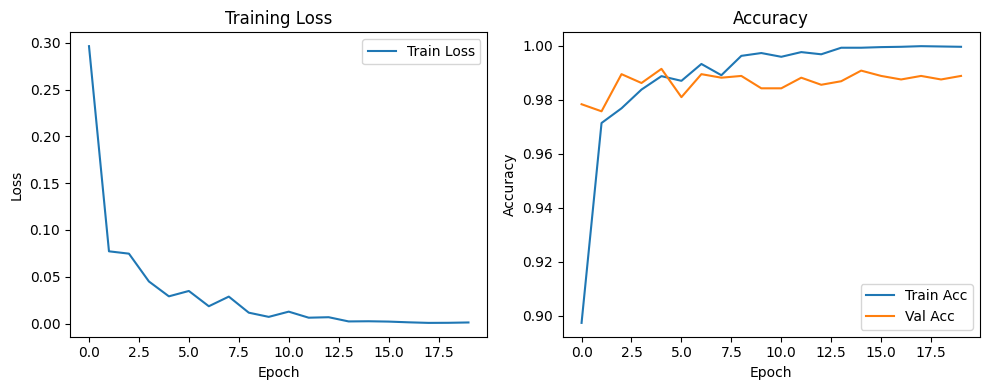

TestA Accuracy: 0.9767

TestA Classification Report:

              precision    recall  f1-score   support

    Basophil       1.00      1.00      1.00        89
  Eosinophil       0.82      0.99      0.90       322
  Lymphocyte       0.98      0.99      0.98      1034
    Monocyte       0.96      0.91      0.93       234
  Neutrophil       1.00      0.97      0.98      2660

    accuracy                           0.97      4339
   macro avg       0.95      0.97      0.96      4339
weighted avg       0.98      0.97      0.98      4339



In [16]:
# ----------------------------
# CONFIGURATION DICTIONARY
# ----------------------------
config = {
    "IMG_SIZE": 224,
    "BATCH_SIZE": 64,
    "EPOCHS": 20,
    "LEARNING_RATE": 1e-4,
    "WEIGHT_DECAY": 1e-5,
    "MODEL_NAME": "vit_tiny_patch16_224",
    "PRETRAINED": True,
    "NUM_CLASSES": 5,
    "TRAIN_SPLIT": 0.85,
    "AUGMENTATION": {
        "HFLIP": 0.5,
        "ROTATION": 10,
    },
    "DATA_PATHS": {
        "TRAIN": "dataset/Train",
        "TEST_A": "dataset/TestA",
        "TEST_B": "dataset/Test-B",
    },
    "NUM_WORKERS": os.cpu_count() // 2
}

# ----------------------------
# TRANSFORMS
# ----------------------------
vit_transform = transforms.Compose([
    transforms.Resize((config["IMG_SIZE"], config["IMG_SIZE"])),
    transforms.RandomHorizontalFlip(p=config["AUGMENTATION"]["HFLIP"]),
    transforms.RandomRotation(config["AUGMENTATION"]["ROTATION"]),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # for grayscale
])

# ----------------------------
# DATASETS AND LOADERS
# ----------------------------
train_dataset = datasets.ImageFolder(root=config["DATA_PATHS"]["TRAIN"], transform=vit_transform)
testA_dataset = datasets.ImageFolder(root=config["DATA_PATHS"]["TEST_A"], transform=vit_transform)
testB_dataset = datasets.ImageFolder(root=config["DATA_PATHS"]["TEST_B"], transform=vit_transform)

train_size = int(config["TRAIN_SPLIT"] * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=config["BATCH_SIZE"], shuffle=True, num_workers=config["NUM_WORKERS"])
val_loader = DataLoader(val_ds, batch_size=config["BATCH_SIZE"], shuffle=False, num_workers=config["NUM_WORKERS"])
testA_loader = DataLoader(testA_dataset, batch_size=config["BATCH_SIZE"], shuffle=False, num_workers=config["NUM_WORKERS"])

# ----------------------------
# MODEL, LOSS, OPTIMIZER
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    config["MODEL_NAME"],
    pretrained=config["PRETRAINED"],
    num_classes=config["NUM_CLASSES"]
).to(device)

# Class Weights
class_indices = [label for _, label in train_ds]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_indices), y=class_indices)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=config["LEARNING_RATE"], weight_decay=config["WEIGHT_DECAY"])
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
scaler = torch.amp.GradScaler()

# ----------------------------
# TRAINING LOOP
# ----------------------------
train_losses, train_accuracies, val_accuracies = [], [], []
best_val_acc = 0.0

for epoch in range(config["EPOCHS"]):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        try:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        except UnidentifiedImageError as e:
            print(f"Skipping corrupted image: {e}")
            continue

    avg_train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_model.pth")

    scheduler.step(val_acc)
    print(f'Epoch {epoch+1}/{config["EPOCHS"]}, '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# ----------------------------
# EVALUATION FUNCTIONS
# ----------------------------
def evaluate_vit(model, loader, name):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"{name} Accuracy: {correct / total:.4f}")

def evaluate_vit_detailed(model, loader, name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f"\n{name} Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=testA_dataset.classes))

# ----------------------------
# PLOT RESULTS
# ----------------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()

# Final
model.load_state_dict(torch.load("best_vit_model.pth"))
evaluate_vit(model, testA_loader, "TestA")
evaluate_vit_detailed(model, testA_loader, "TestA")

Conclusion:


Comparing The Results:
To show how these three different models compare, here we make a graph to... (COME BACK)

Conclusion:
Looking at this data.......

Contributions:
Throughout the course of this notebook, we have all worked collaboratively on this assignment. But here is an outline of tasks that each of us have completed:

Ziqiu:
- Ziqiu's main focus was on the Vision Transformer.
- Wrote the Intro.
- Updated the importing of data into train and test splits.
- Visually demonstrated the distribution of datasets.
- Made the sampler function with balanced class weights. - Wrote various documentation throughout this notebook.

Justen:
- Justen's main focus was on the Convoluted Neural Network.
- Set up and coordinated our GitHub repository.
- Wrote various documentation throughout this notebook.

Carter:
- Carters main focus was on the Decision Tree.
- Worked on importing the data into train and test splits, which were later updated by Ziqiu.
- Wrote various documentation throughout this notebook.